In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Data Generator

PATH = './data_set'

BATCH_SIZE = 16
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(PATH,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset='training',
                                                            seed=123,
                                                            validation_split=0.3)

validation_dataset = tf.keras.utils.image_dataset_from_directory(PATH,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset='validation',
                                                                 seed=123,
                                                                 validation_split=0.3)

Found 143 files belonging to 2 classes.
Using 101 files for training.
Found 143 files belonging to 2 classes.
Using 42 files for validation.


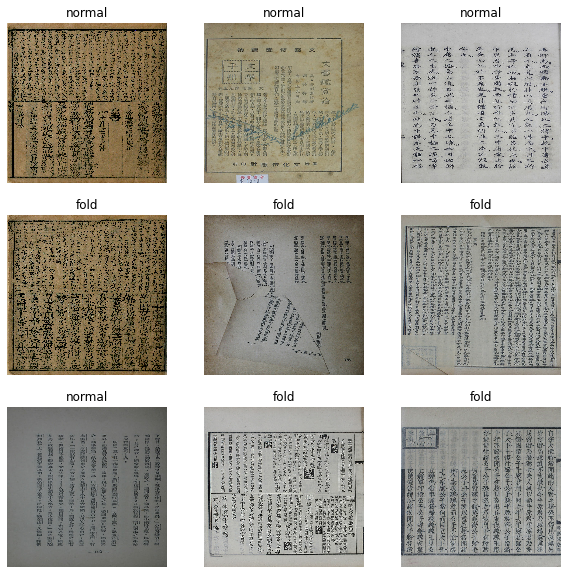

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [7]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Use data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.01),
])

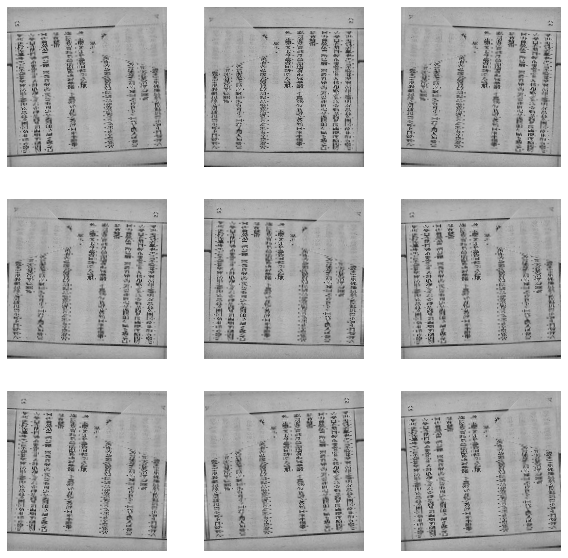

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
# Rescale pixel values
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(input_shape=IMG_SHAPE,
                                                                   include_top=False,
                                                                   weights='imagenet')

82420632/82420632 [==============================] - 2s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape) # 160*160*3 -> 5*5*1280

(16, 5, 5, 1280)


In [13]:
# Feature extraction
base_model.trainable = False
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 80, 80, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 80, 80, 24)   96          ['stem_conv[0][0]'

In [14]:
# Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1) # 2 classes
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [16]:
# Model Layer
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 5, 5, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [18]:
initial_epochs = 30
loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 4s 234ms/step - loss: 0.7216 - accuracy: 0.5769


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.58


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
7/7 [==============================] - 12s 471ms/step - loss: 0.7214 - accuracy: 0.5050 - val_loss: 0.6585 - val_accuracy: 0.4231
Epoch 2/30
7/7 [==============================] - 3s 440ms/step - loss: 0.7011 - accuracy: 0.5446 - val_loss: 0.7093 - val_accuracy: 0.5000
Epoch 3/30
7/7 [==============================] - 3s 435ms/step - loss: 0.6857 - accuracy: 0.5644 - val_loss: 0.6822 - val_accuracy: 0.4231
Epoch 4/30
7/7 [==============================] - 3s 437ms/step - loss: 0.6674 - accuracy: 0.5941 - val_loss: 0.7284 - val_accuracy: 0.4615
Epoch 5/30
7/7 [==============================] - 3s 440ms/step - loss: 0.6596 - accuracy: 0.6436 - val_loss: 0.6816 - val_accuracy: 0.3846
Epoch 6/30
7/7 [==============================] - 3s 440ms/step - loss: 0.6352 - accuracy: 0.5842 - val_loss: 0.6122 - val_accuracy: 0.5769
Epoch 7/30
7/7 [==============================] - 3s 450ms/step - loss: 0.6303 - accuracy: 0.6040 - val_loss: 0.6545 - val_accuracy: 0.4615
Epoch 8/30
7/7 [===

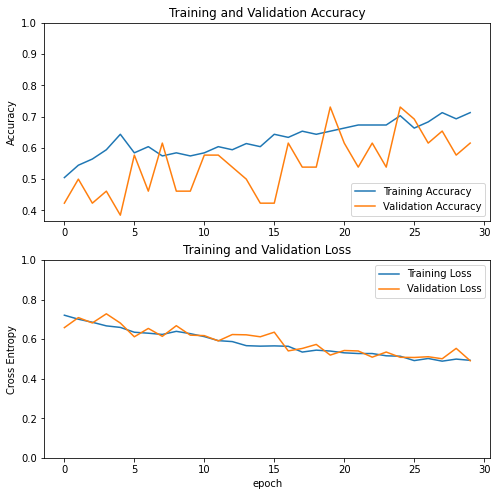

In [21]:
# Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# Fine tuning

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  513


In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 5, 5, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [29]:
len(model.trainable_variables)

187

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/40
7/7 [==============================] - 21s 1s/step - loss: 0.4716 - accuracy: 0.7624 - val_loss: 0.4219 - val_accuracy: 0.7308
Epoch 31/40
7/7 [==============================] - 6s 768ms/step - loss: 0.3784 - accuracy: 0.8020 - val_loss: 0.3729 - val_accuracy: 0.8077
Epoch 32/40
7/7 [==============================] - 6s 816ms/step - loss: 0.3488 - accuracy: 0.8119 - val_loss: 0.3020 - val_accuracy: 0.8846
Epoch 33/40
7/7 [==============================] - 6s 758ms/step - loss: 0.3086 - accuracy: 0.8416 - val_loss: 0.3086 - val_accuracy: 0.8846
Epoch 34/40
7/7 [==============================] - 6s 752ms/step - loss: 0.2539 - accuracy: 0.9010 - val_loss: 0.2897 - val_accuracy: 0.9231
Epoch 35/40
7/7 [==============================] - 5s 737ms/step - loss: 0.2392 - accuracy: 0.9109 - val_loss: 0.3049 - val_accuracy: 0.8462
Epoch 36/40
7/7 [==============================] - 5s 739ms/step - loss: 0.1947 - accuracy: 0.9010 - val_loss: 0.2568 - val_accuracy: 0.8846
Epoch 37/40
7/7

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

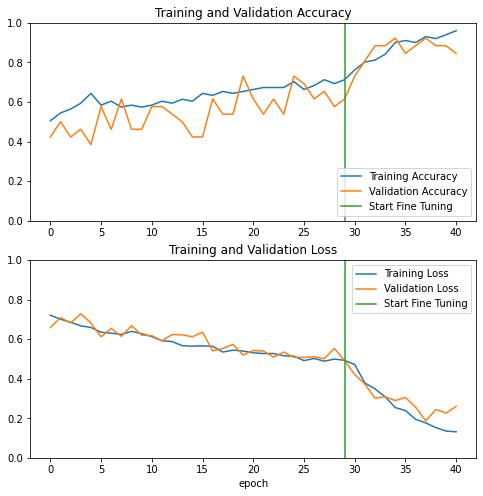

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 640ms/step - loss: 0.1210 - accuracy: 0.9375
Test accuracy : 0.9375


Predictions:
 [1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0]
Labels:
 [1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1]


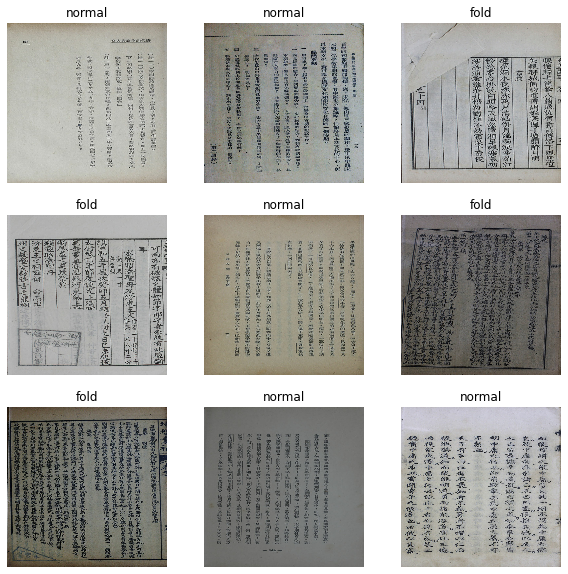

In [65]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
!mkdir saved_model
model.save('saved_model/my_model')